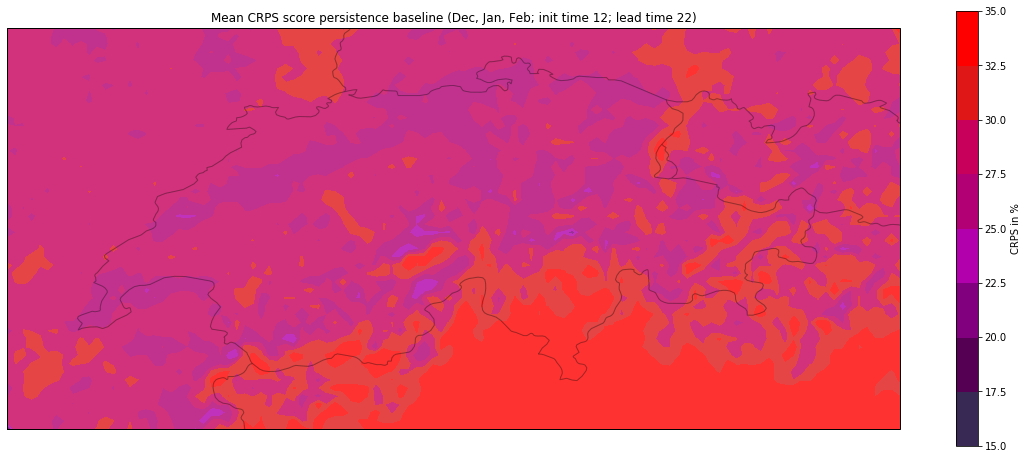

In [1]:
%matplotlib inline

import os
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cft
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

filepath = os.path.join("..", "local_playground", "persistence_CRPS_winter_it12_lt22.pkl")
outpath = os.path.join("..", "local_playground", "map_example.png")
time = None  # Set to a pandas Timestamp, or to None to get the mean over all times. 
clim = (15, 35)

## import data
df = pd.read_pickle(filepath).reset_index(["lat", "lon"])
lon = np.unique(df["lon"])
lat = np.unique(df["lat"])
CRPS = df.iloc[(df.time == time).values].CRPS.values.reshape((len(lat), len(lon))) if time else np.transpose(
    df.groupby(["lon", "lat"]).mean().values.reshape((len(lon), len(lat))))
CRPS = np.clip(CRPS, clim[0], clim[1])
CRPS[0, 0] = clim[0]
CRPS[-1, -1] = clim[1]

## make the plot
borders = cft.NaturalEarthFeature("cultural", "admin_0_countries", "10m")
fig = plt.figure(figsize=(20, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([min(lon), max(lon), min(lat), max(lat)])
ax.add_feature(borders, facecolor=(1, 1, 1), alpha=.2, linewidth=1, edgecolor="black")
cs = plt.contourf(lon, lat, CRPS, transform=ccrs.PlateCarree(), 
                  colors=["#372854", "#560054", "#81007d", "#b200ac", "#b20074", "#c8005b", "#df1717", "#ff0000"])
cbar = plt.colorbar(cs)
cbar.ax.set_ylabel("CRPS in %")
# plt.title("CRPS score (" + (time.strftime("%Y.%m.%d %H:%M") if time else "mean") + ", lead time 22)")
plt.title("Mean CRPS score persistence baseline (Dec, Jan, Feb; init time 12; lead time 22)")

## save and show the plot
plt.savefig(outpath, dpi=100, format="png")
plt.show()
plt.close(1)

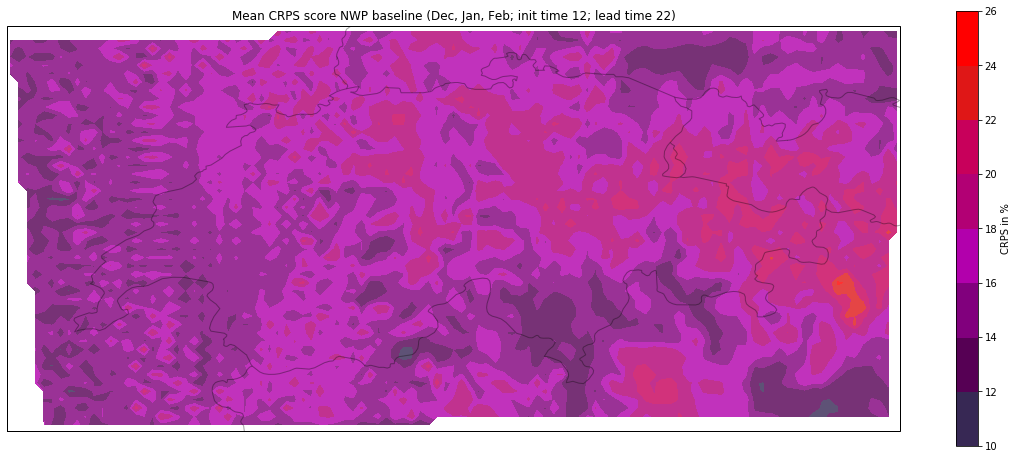

In [2]:
%matplotlib inline

import os
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import cartopy.crs as ccrs
import cartopy.feature as cft
import pandas as pd
import numpy as np
import dask.dataframe as dd
from mpl_toolkits.axes_grid1 import make_axes_locatable

filepath = os.path.join("..", "local_playground", "nwp_crps_scores_winter_it12_lt22.pkl")
outpath = os.path.join("..", "local_playground", "map_example.png")
time = None  # Set to a pandas Timestamp, or to None to get the mean over all times. 
clim = (15, 35)

## import data
df = pd.read_pickle(filepath).reset_index(["lat", "lon"])
# lon_unif = np.linspace(np.min(lon), np.max(lon), 120)
lon_unif = np.array([ 5.525,  5.575,  5.625,  5.675,  5.725,  5.775,  5.825,  5.875,
        5.925,  5.975,  6.025,  6.075,  6.125,  6.175,  6.225,  6.275,
        6.325,  6.375,  6.425,  6.475,  6.525,  6.575,  6.625,  6.675,
        6.725,  6.775,  6.825,  6.875,  6.925,  6.975,  7.025,  7.075,
        7.125,  7.175,  7.225,  7.275,  7.325,  7.375,  7.425,  7.475,
        7.525,  7.575,  7.625,  7.675,  7.725,  7.775,  7.825,  7.875,
        7.925,  7.975,  8.025,  8.075,  8.125,  8.175,  8.225,  8.275,
        8.325,  8.375,  8.425,  8.475,  8.525,  8.575,  8.625,  8.675,
        8.725,  8.775,  8.825,  8.875,  8.925,  8.975,  9.025,  9.075,
        9.125,  9.175,  9.225,  9.275,  9.325,  9.375,  9.425,  9.475,
        9.525,  9.575,  9.625,  9.675,  9.725,  9.775,  9.825,  9.875,
        9.925,  9.975, 10.025, 10.075, 10.125, 10.175, 10.225, 10.275,
       10.325, 10.375, 10.425, 10.475, 10.525, 10.575, 10.625, 10.675,
       10.725, 10.775, 10.825, 10.875, 10.925, 10.975])
lon = df["lon"][0:21240]
# lat_unif = np.linspace(np.min(lat), np.max(lat), 177)
lat_unif = np.array([45.525, 45.575, 45.625, 45.675, 45.725, 45.775, 45.825, 45.875,
       45.925, 45.975, 46.025, 46.075, 46.125, 46.175, 46.225, 46.275,
       46.325, 46.375, 46.425, 46.475, 46.525, 46.575, 46.625, 46.675,
       46.725, 46.775, 46.825, 46.875, 46.925, 46.975, 47.025, 47.075,
       47.125, 47.175, 47.225, 47.275, 47.325, 47.375, 47.425, 47.475,
       47.525, 47.575, 47.625, 47.675, 47.725, 47.775, 47.825, 47.875,
       47.925, 47.975])
lat = df["lat"][0:21240]
# CRPS = df.iloc[(df.time == time).values].CRPS.values.reshape((len(lat), len(lon))) if time else np.transpose(
#     df.groupby(["lon", "lat"]).mean().values.reshape((len(lon), len(lat))))
df = dd.from_pandas(df, npartitions=8)
CRPS = df.groupby(["lon", "lat"]).mean().to_dask_array(lengths=True).reshape((21240,))

triang = tri.Triangulation(lon, lat)
interpolator = tri.LinearTriInterpolator(triang, CRPS)
Lon_unif, Lat_unif = np.meshgrid(lon_unif, lat_unif)
CRPS_unif = interpolator(Lon_unif, Lat_unif)
CRPS_unif = np.clip(CRPS_unif, clim[0], clim[1])
CRPS_unif[0, 0] = clim[0]
CRPS_unif[-1, -1] = clim[1]

## make the plot
borders = cft.NaturalEarthFeature("cultural", "admin_0_countries", "10m")
fig = plt.figure(figsize=(20, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([min(lon), max(lon), min(lat), max(lat)])
ax.add_feature(borders, facecolor=(1, 1, 1), alpha=.2, linewidth=1, edgecolor="black")
cs = plt.contourf(Lon_unif, Lat_unif, CRPS_unif, transform=ccrs.PlateCarree(), 
                  colors=["#372854", "#560054", "#81007d", "#b200ac", "#b20074", "#c8005b", "#df1717", "#ff0000"])
cbar = plt.colorbar(cs)
cbar.ax.set_ylabel("CRPS in %")
# plt.title("CRPS score (" + (time.strftime("%Y.%m.%d %H:%M") if time else "mean") + ", lead time 22)")
plt.title("Mean CRPS score NWP baseline (Dec, Jan, Feb; init time 12; lead time 22)")

## save and show the plot
plt.savefig(outpath, dpi=100, format="png")
plt.show()
plt.close(1)